In [1]:
import os
import re
import time
import datetime
import json
import csv

import pandas as pd
from tqdm import tqdm
## read/write pickle

import pickle
import pandas as pd

from openai import OpenAI
import tiktoken
import gzip
import seaborn as sns
import numpy as np
import ast

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
import nq_swap_inference as inference
import read_nqswap_dataset as read_ds
import string_utils
import constants

import importlib
importlib.reload(read_ds)

<module 'read_nqswap_dataset' from '/home/al2644/research/codebase/read_nqswap_dataset.py'>

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

In [5]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", padding_side = 'left')

# Sept 26

## Raw Dataset

In [5]:
def get_raw_df (dataset_name, with_context, teacher_forcing_dataset_name = None):
    df = read_ds.load_input_dataset(dataset_name=dataset_name, with_context=with_context,
                        prefix_prompt=constants.PREFIX_PROMPT, teacher_forcing_dataset_name=None)
    columns = ['query', 'ground_truth', 'input']
    df = df[columns].drop_duplicates(subset=['input'])

    return df

In [6]:
raw_org_nocontext_df = get_raw_df('original', False)
raw_org_context_df = get_raw_df('original', True)
raw_sub_context_df = get_raw_df('corpus-substitution', True)

In [22]:
idx = 150
raw_sub_context_df['query'][idx]

'when did the astros change from the national league to the american league'

In [8]:
'''find queries that can be substitued'''
queries = list(raw_sub_context_df['query'].unique())
raw_org_nocontext_df = raw_org_nocontext_df[raw_org_nocontext_df['query'].isin(queries)]
raw_org_context_df = raw_org_context_df[raw_org_context_df['query'].isin(queries)]

## Inference

In [41]:
org_nocontext_df = read_ds.read_logprob_output(type = 'Dev', dataset_name='original', with_context=False)
org_context_df = read_ds.read_logprob_output(type = 'Dev', dataset_name='original', with_context=True)
sub_context_df = read_ds.read_logprob_output(type = 'Dev', dataset_name='corpus-substitution', with_context=True)

## Teacher Forcing

In [42]:
org_nocontext_org_teacher_df = read_ds.read_logprob_output(type = 'Dev', dataset_name='original', with_context=False, teacher_dataset_name='original')
org_context_org_teacher_df = read_ds.read_logprob_output(type = 'Dev', dataset_name='original', with_context=True, teacher_dataset_name='original')
sub_context_org_teacher_df = read_ds.read_logprob_output(type = 'Dev', dataset_name='corpus-substitution', with_context=True, teacher_dataset_name='original')
sub_context_sub_teacher_df = read_ds.read_logprob_output(type = 'Dev', dataset_name='corpus-substitution', with_context=True, teacher_dataset_name='corpus-substitution')

## Get Accuracy

In [157]:
def get_accuracy (input_raw_df, input_inference_df, reference_name = 'ground_truth', test_name = 'decoded_answer'):
    raw_df, inference_df = input_raw_df.copy(deep = True), input_inference_df.copy(deep = True)
    df = raw_df.merge(inference_df, on = 'input')

    df[f'{reference_name}_set'] = df[reference_name].apply(lambda x: set(sum([ans.split(' ') for ans in x], [])))
    df[f'{test_name}_set'] = df[test_name].apply(lambda x: set(x.split(' ')))
    df['match'] = df.apply(lambda row: len(row[f'{reference_name}_set'].intersection(row[f'{test_name}_set'])) > 0, axis = 1)

    df.drop(columns = [f'{reference_name}_set', f'{test_name}_set'], inplace = True)

    return df

def get_logprob (input_raw_df, input_teacher_ans_logprob_df, reference_name = 'ground_truth', logprob_colname = 'teacher_answer_log_prob'):
    raw_df, teacher_ans_logprob_df = input_raw_df.copy(deep = True), input_teacher_ans_logprob_df.copy(deep = True)
    raw_df.drop(columns=[reference_name], inplace =True)
    teacher_ans_max_logprob_df = teacher_ans_logprob_df.groupby('input')[logprob_colname].max().reset_index()
    df = raw_df.merge(teacher_ans_max_logprob_df, on = ['input'])

    return df
def compute_quantiles (df, logprob_col = 'teacher_answer_log_prob', match_col = 'match', output_logprob_col = 'avg_teacher_answer_logprob', acc_col = 'avg_match_teacher_answer_accuracy'):
    
    quantiles = [x / 100 for x in range(0, 110, 10)]
    logprob_quantiles = df[logprob_col].quantile(quantiles).reset_index().rename(columns = {'index': 'quantile', logprob_col: 'value'})
    up, low = df[logprob_col].quantile(0.99), df[logprob_col].quantile(0.01)
    df = df[df[logprob_col].between(low, up)]

    avg_logprob, avg_acc = [], []
    for i in range(1, len(logprob_quantiles)):
        chunk_df = df[df[logprob_col].between(logprob_quantiles['value'].loc[i - 1], logprob_quantiles['value'][i])]
        avg_logprob.append(chunk_df[logprob_col].mean())
        avg_acc.append(chunk_df[match_col].sum() / len(chunk_df))
    logprob_quantiles = logprob_quantiles[1:].reset_index(drop = True)
    logprob_quantiles[output_logprob_col] = avg_logprob
    logprob_quantiles[acc_col] = avg_acc
    
    return logprob_quantiles

In [147]:
def logprob_accuracy_match_ground_truth (raw_df, inference_df, teacher_ans_logprob_df):
    acc_df = get_accuracy(raw_df, inference_df)
    teacher_logprob_df = get_logprob(raw_df, teacher_ans_logprob_df)
    acc_df.drop(columns = ['ground_truth', 'decoded_answer', 'inference_answer_log_prob'], inplace = True)

    df = acc_df.merge(teacher_logprob_df, on = ['query', 'input'])
    
    quantiles = [x / 100 for x in range(0, 110, 10)]
    logprob_quantiles = df['teacher_answer_log_prob'].quantile(quantiles).reset_index().rename(columns = {'index': 'quantile', 'teacher_answer_log_prob': 'value'})
    up, low = df['teacher_answer_log_prob'].quantile(0.99), df['teacher_answer_log_prob'].quantile(0.01)
    df = df[df['teacher_answer_log_prob'].between(low, up)]

    avg_logprob, avg_acc = [], []
    for i in range(1, len(logprob_quantiles)):
        chunk_df = df[df['teacher_answer_log_prob'].between(logprob_quantiles['value'].loc[i - 1], logprob_quantiles['value'][i])]
        avg_logprob.append(chunk_df['teacher_answer_log_prob'].mean())
        avg_acc.append(chunk_df['match'].sum() / len(chunk_df))
    logprob_quantiles = logprob_quantiles[1:].reset_index(drop = True)
    logprob_quantiles['avg_teacher_answer_logprob'] = avg_logprob
    logprob_quantiles['avg_match_ground_truth_accuracy'] = avg_acc

    return logprob_quantiles

def logprob_accuracy_match_teacher (raw_df, inference_df, teacher_ans_logprob_df):
    teacher_reference_df = teacher_ans_logprob_df[['input', 'teacher_answer']].groupby('input')['teacher_answer'].agg(list).reset_index()
    acc_df = get_accuracy(teacher_reference_df, inference_df, reference_name='teacher_answer')
    acc_df = acc_df[['input', 'match']]
    
    teacher_logprob_df = get_logprob(raw_df, teacher_ans_logprob_df)
    df = acc_df.merge(teacher_logprob_df, on = 'input')
    
    quantiles = [x / 100 for x in range(0, 110, 10)]
    logprob_quantiles = df['teacher_answer_log_prob'].quantile(quantiles).reset_index().rename(columns = {'index': 'quantile', 'teacher_answer_log_prob': 'value'})
    up, low = df['teacher_answer_log_prob'].quantile(0.99), df['teacher_answer_log_prob'].quantile(0.01)
    df = df[df['teacher_answer_log_prob'].between(low, up)]

    avg_logprob, avg_acc = [], []
    for i in range(1, len(logprob_quantiles)):
        chunk_df = df[df['teacher_answer_log_prob'].between(logprob_quantiles['value'].loc[i - 1], logprob_quantiles['value'][i])]
        avg_logprob.append(chunk_df['teacher_answer_log_prob'].mean())
        avg_acc.append(chunk_df['match'].sum() / len(chunk_df))
    logprob_quantiles = logprob_quantiles[1:].reset_index(drop = True)
    logprob_quantiles['avg_teacher_answer_logprob'] = avg_logprob
    logprob_quantiles['avg_match_teacher_answer_accuracy'] = avg_acc

    return logprob_quantiles

In [150]:
org_nocontext_orgteacher_logprob_acc = logprob_accuracy_match_ground_truth(raw_org_nocontext_df, org_nocontext_df, org_nocontext_org_teacher_df)
org_context_orgteacher_logprob_acc = logprob_accuracy_match_ground_truth(raw_org_context_df, org_context_df, org_context_org_teacher_df)
sub_context_subteacher_logprob_acc = logprob_accuracy_match_ground_truth(raw_sub_context_df, sub_context_df, sub_context_sub_teacher_df)

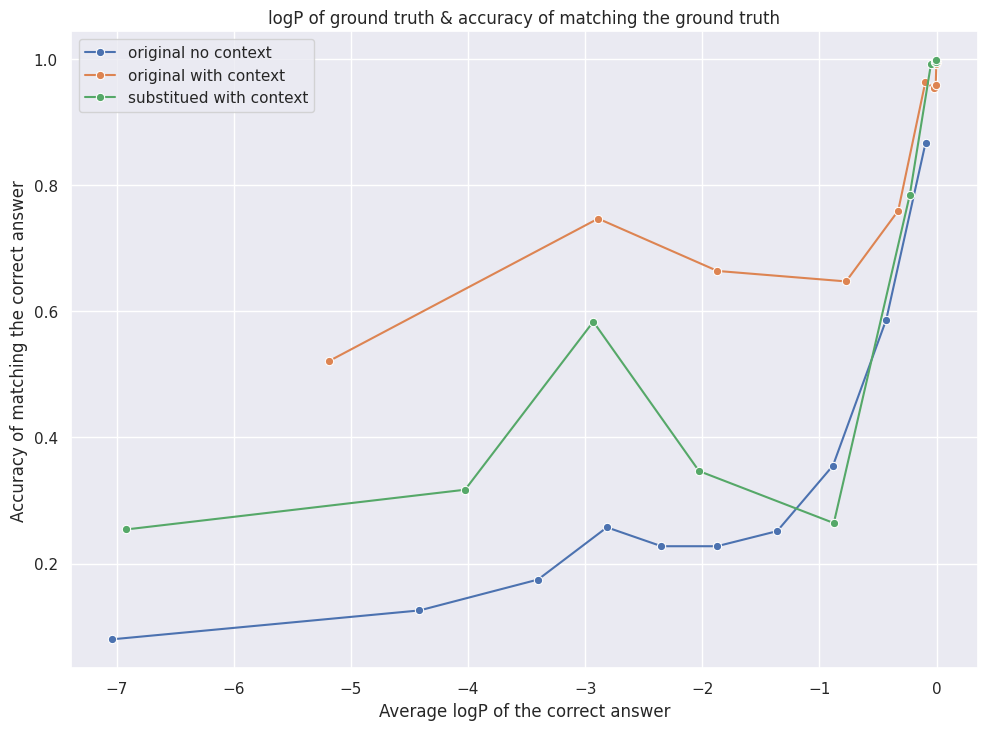

In [191]:
sns.lineplot(data=org_nocontext_orgteacher_logprob_acc, x="avg_teacher_answer_logprob", y="avg_match_ground_truth_accuracy", marker='o', label="original no context")
sns.lineplot(data=org_context_orgteacher_logprob_acc, x="avg_teacher_answer_logprob", y="avg_match_ground_truth_accuracy", marker='o', label="original with context")
sns.lineplot(data=sub_context_subteacher_logprob_acc, x="avg_teacher_answer_logprob", y="avg_match_ground_truth_accuracy", marker='o', label="substitued with context")

plt.xlabel('Average logP of the correct answer')
plt.ylabel('Accuracy of matching the correct answer')
plt.title('logP of ground truth & accuracy of matching the ground truth')
plt.legend()
plt.show()

In [175]:
sub_context_orgteacher_logprob_acc = logprob_accuracy_match_ground_truth(raw_sub_context_df, sub_context_df, sub_context_org_teacher_df)
sub_context_orgteacher_logprob_match_teacher_acc = logprob_accuracy_match_teacher(raw_sub_context_df, sub_context_df, sub_context_org_teacher_df)

In [212]:
idx = 0 
raw_sub_context_df['input'][idx]

'Instruction: In a few words, give a direct answer to the below question in an accurate and concise way.\nsource:  The fourth season of Chicago Fire , an American drama television series with executive producer Dick Wolf , and producers Derek Haas , Michael Brandt , and Matt Olmstead , was ordered on February 5 , 2015 , by NBC , and premiered on October 13 , 2015 and concluded on May 17 , 2016 . The season contained 138 episodes . \nquestion: how many episodes are in chicago fire season 4\nanswer: '

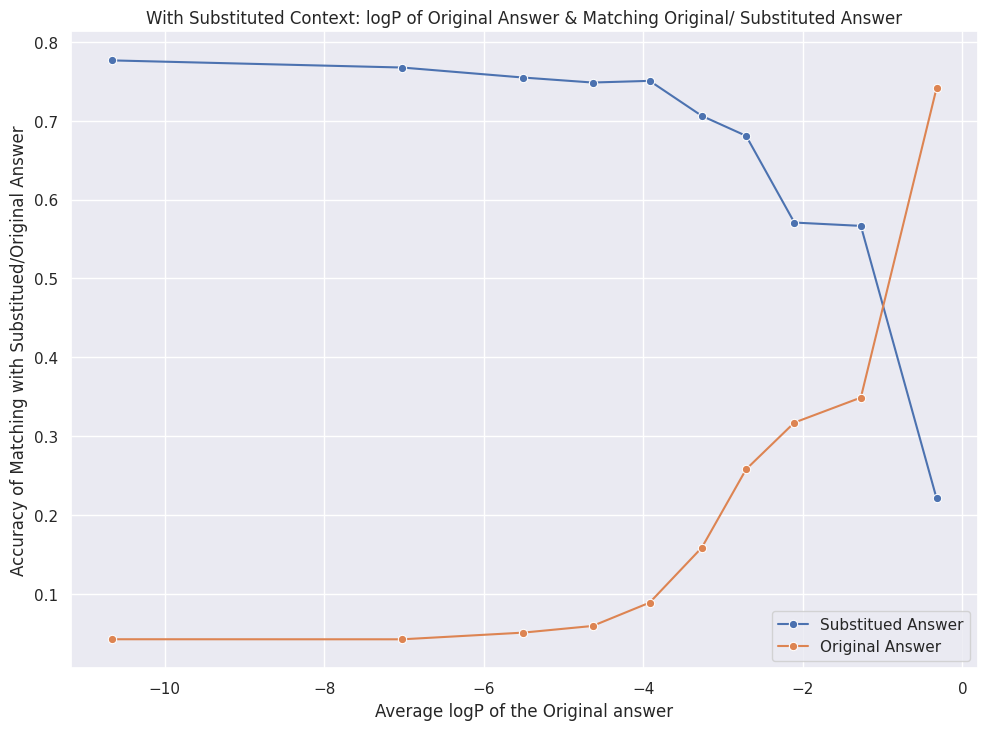

In [197]:
sns.lineplot(data=sub_context_orgteacher_logprob_acc, x="avg_teacher_answer_logprob", y="avg_match_ground_truth_accuracy", marker='o', label="Substitued Answer")
sns.lineplot(data=sub_context_orgteacher_logprob_match_teacher_acc, x="avg_teacher_answer_logprob", y="avg_match_teacher_answer_accuracy", marker='o', label="Original Answer")

plt.xlabel('Average logP of the Original answer')
plt.ylabel('Accuracy of Matching with Substitued/Original Answer')
plt.title('With Substituted Context: logP of Original Answer & Matching Original/ Substituted Answer')
plt.legend()
plt.show()

## Comparison

In [29]:
raw_df, inference_df = raw_sub_context_df, sub_context_df
acc_df = get_accuracy(raw_df,inference_df).rename(columns = {'match': 'match_sub_teacher_answer'})

org_teacher = sub_context_org_teacher_df.rename(columns = {'teacher_answer' : 'org_teacher_answer', 'teacher_answer_log_prob' : 'org_teacher_answer_logprob'})
sub_teacher = sub_context_sub_teacher_df.rename(columns = {'teacher_answer' :'sub_teacher_answer' , 'teacher_answer_log_prob' : 'sub_teacher_answer_logprob'})

In [33]:
comparison_df = org_teacher.merge(sub_teacher, on = 'input').merge(acc_df[['input', 'match_sub_teacher_answer']], on = 'input')
comparison_df['diff'] = comparison_df['sub_teacher_answer_logprob'] - comparison_df['org_teacher_answer_logprob']

Text(0.5, 1.0, 'With Substituted Context: Distribution of logP(substitued answer) - logP(original answer)')

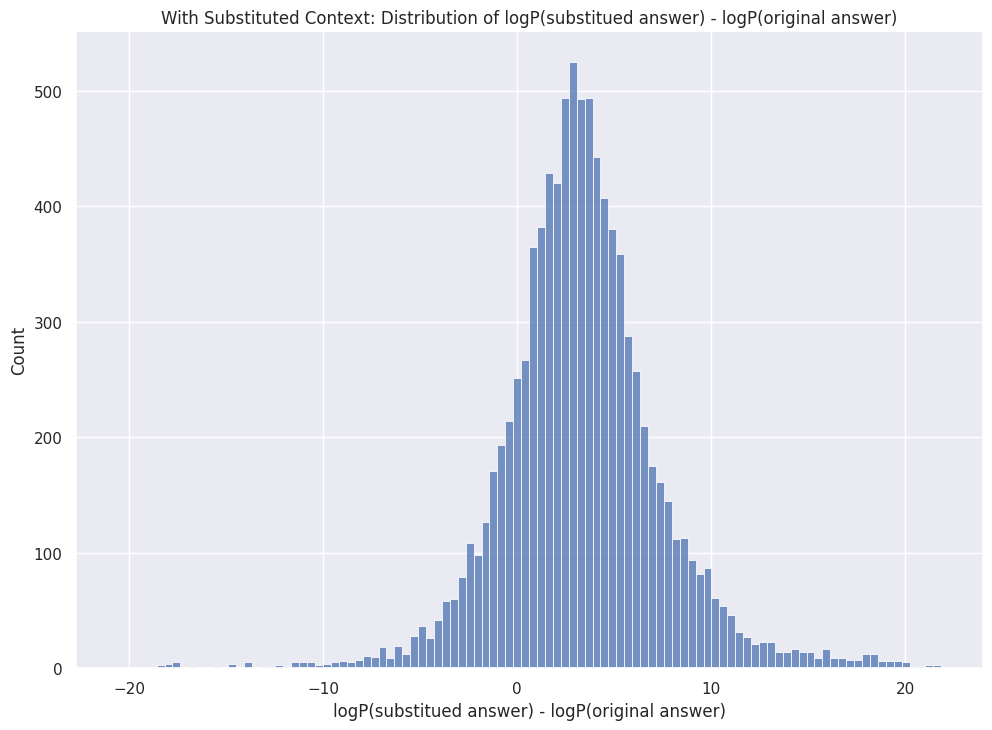

In [194]:
axs = sns.histplot(comparison_df['diff'])
axs.set_xlabel('logP(substitued answer) - logP(original answer)')
axs.set_title('With Substituted Context: Distribution of logP(substitued answer) - logP(original answer)')

In [161]:
diff_quantiles = compute_quantiles(df = comparison_df, logprob_col = 'diff', match_col = 'match_sub_teacher_answer', output_logprob_col = 'avg_logprob_diff', acc_col = 'avg_match_sub_answer_accuracy')

In [164]:
diff_quantiles

,quantile,value,avg_logprob_diff,avg_match_sub_answer_accuracy
0,0.1,-1.164802,-3.028294,0.103819
1,0.2,0.528767,-0.260382,0.273899
2,0.3,1.551163,1.057874,0.550429
3,0.4,2.434463,1.997571,0.676692
4,0.5,3.157796,2.798271,0.754292
5,0.6,3.950449,3.543940,0.805794
6,0.7,4.850485,4.384820,0.832438
7,0.8,5.998972,5.383114,0.872318
8,0.9,8.042087,6.906737,0.879699
9,1.0,21.853625,10.396783,0.866348


Text(0.5, 1.0, 'With Substitued Context: logP(substitued answer) - logP(original answer) & Accuracy of Matching Substituted Answer')

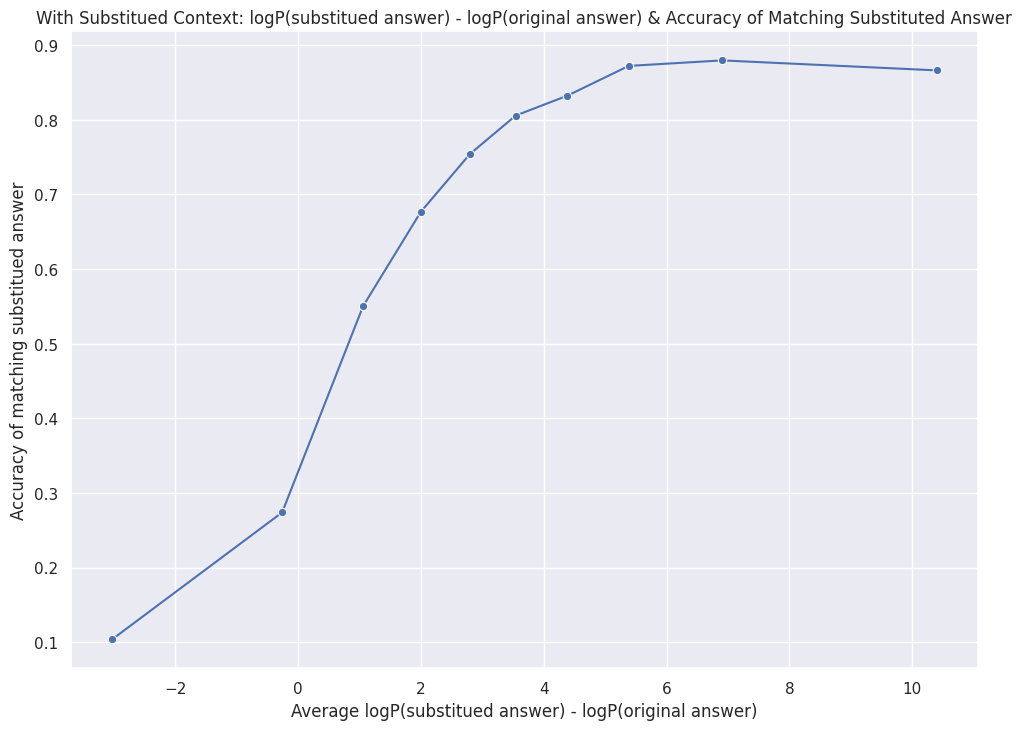

In [195]:
ax = sns.lineplot(data=diff_quantiles,
             x="avg_logprob_diff", y="avg_match_sub_answer_accuracy", marker='o')
ax.set_xlabel('Average logP(substitued answer) - logP(original answer)')
ax.set_ylabel('Accuracy of matching substitued answer')
ax.set_title('With Substitued Context: logP(substitued answer) - logP(original answer) & Accuracy of Matching Substituted Answer')

# Sept 24

# Get DF

In [352]:
columns = ['query', 'ground_truth', 'ground_truth_tokens', 'ground_truth_token_ids', 'input']
raw_original_df = read_tokenized_dataset(root = '/home/al2644/research/datasets/NQ-swap/tokenized_ground_truth_df', suffix='tokenized',
                                          type = 'Dev', dataset_name = 'original', with_context=False)[columns]
raw_original_context_df = read_tokenized_dataset(root = '/home/al2644/research/datasets/NQ-swap/tokenized_ground_truth_df', suffix='tokenized',
                                          type = 'Dev', dataset_name = 'original', with_context=True)[columns]
substitute_context_df = read_tokenized_dataset(root = '/home/al2644/research/datasets/NQ-swap/tokenized_ground_truth_df', suffix='tokenized',
                                          type = 'Dev', dataset_name = 'corpus-substitution', with_context=True)[columns]

In [428]:
raw_original_df

,query,ground_truth,ground_truth_tokens,ground_truth_token_ids,input
0,what is non controlling interest on balance sheet,"[""the portion of a subsidiary corporation 's s...","['portion', 'subsidiary', 'corporation', 'stoc...","[11910, 11684, 8819, 653, 17266, 362, 10961, 1...",Instruction: answer the below question in an a...
1,how many episodes are in chicago fire season 4,['23'],['23'],"[29871, 29906, 29941]",Instruction: answer the below question in an a...
2,how many episodes are in chicago fire season 4,['23'],['23'],"[29871, 29906, 29941]",Instruction: answer the below question in an a...
3,who sings love will keep us alive by the eagles,['Timothy B. Schmit'],"['Timothy', 'B.', 'Schmit']","[7870, 20336, 350, 29889, 1102, 2415]",Instruction: answer the below question in an a...
4,how many episodes are in chicago fire season 4,['23'],['23'],"[29871, 29906, 29941]",Instruction: answer the below question in an a...
...,...,...,...,...,...
12831,who does eric end up with in that 70s show,['Donna'],['Donna'],"[3872, 1056]",Instruction: answer the below question in an a...
12832,what is the longest river in the united states,['Missouri River'],"['Missouri', 'River']","[19171, 6163]",Instruction: answer the below question in an a...
12833,what is the longest river in the united states,['Missouri River'],"['Missouri', 'River']","[19171, 6163]",Instruction: answer the below question in an a...
12834,what is the longest river in the united states,['Missouri River'],"['Missouri', 'River']","[19171, 6163]",Instruction: answer the below question in an a...


In [361]:
ROOT = '/home/al2644/research/datasets/NQ-swap/logprob_results'
original_logprob_df = pd.read_csv(os.path.join(ROOT, 'MRQANaturalQuestionsDev-original-context=False_logprob.csv'))
original_context_logprob_df = pd.read_csv(os.path.join(ROOT, 'MRQANaturalQuestionsDev-original-context=True_logprob.csv'))
substitute_logprob_df = pd.read_csv(os.path.join(ROOT, 'MRQANaturalQuestionsDev-corpus-substitution-context=True_logprob.csv'))

In [362]:
# merge input df with logprob df
original_df = raw_original_df.merge(original_logprob_df, on = 'input')
original_df.columns = [col + '_org_no_context' if col != 'query' else 'query' for col in original_df.columns]

original_context_df = raw_original_context_df.merge(original_context_logprob_df, on = 'input')
original_context_df.columns = [col + '_org_context' if col != 'query' else 'query' for col in original_context_df.columns]

substitute_df = substitute_context_df.merge(substitute_logprob_df, on = 'input')
substitute_df.columns = [col + '_substitute_context' if col != 'query' else 'query' for col in substitute_df.columns]

In [363]:
# drop duplicates for the original ones
original_df = original_df.drop_duplicates(subset=['query'])
original_context_df = original_context_df.drop_duplicates(subset=['query'])

# Analysis

## Examples

In [293]:
substitute_df['ans_logprob_substitute_context'].describe()

count    3.603000e+03
mean    -7.013926e-02
std      1.273671e-01
min     -1.457981e+00
25%     -8.246943e-02
50%     -2.227238e-02
75%     -4.318876e-03
max     -5.364420e-07
Name: ans_logprob_substitute_context, dtype: float64

In [449]:
i = 1
query = substitute_df['query'][i]
print('ground truth: ',substitute_df['ground_truth_substitute_context'][i], '\n', '-' * 20)
print('output seq: ',substitute_df['decoded_ouput_substitute_context'][i], '\n', '-' * 20)
print('EM logprob: ',substitute_df['ans_logprob_substitute_context'][i])


ground truth:  ['1624'] 
 --------------------
output seq:  Instruction: answer the below question in an accurate, concise way.
source:  The fourth season of Chicago Fire , an American drama television series with executive producer Dick Wolf , and producers Derek Haas , Michael Brandt , and Matt Olmstead , was ordered on February 5 , 2015 , by NBC , and premiered on October 13 , 2015 and concluded on May 17 , 2016 . The season contained 1624 episodes . 
question: how many episodes are in chicago fire season 4
answer: 16 episodes 
 --------------------
EM logprob:  -0.0022674774976308


In [450]:
print('ground truth: ',original_context_df['ground_truth_org_context'][original_context_df['query'] == query].iloc[0], '\n', '-' * 20)
print('output seq: ',original_context_df['decoded_ouput_org_context'][original_context_df['query'] == query].iloc[0], '\n', '-' * 20)
print('EM logprob: ',original_context_df['ans_logprob_org_context'][original_context_df['query'] == query].iloc[0])

ground truth:  ['23'] 
 --------------------
output seq:  Instruction: answer the below question in an accurate, concise way.
source:  The fourth season of Chicago Fire , an American drama television series with executive producer Dick Wolf , and producers Derek Haas , Michael Brandt , and Matt Olmstead , was ordered on February 5 , 2015 , by NBC , and premiered on October 13 , 2015 and concluded on May 17 , 2016 . The season contained 23 episodes . 
question: how many episodes are in chicago fire season 4
answer: 23 episodes 
 --------------------
EM logprob:  -0.0003250549805946


In [433]:
print('ground truth: ',original_df['ground_truth_org_no_context'][original_df['query'] == query].iloc[0], '\n', '-' * 20)
print('output seq: ',original_df['decoded_ouput_org_no_context'][original_df['query'] == query].iloc[0], '\n', '-' * 20)
print('EM logprob: ',original_df['ans_logprob_org_no_context'][original_df['query'] == query].iloc[0])

ground truth:  ['23'] 
 --------------------
output seq:  Instruction: answer the below question in an accurate, concise way.
question: how many episodes are in chicago fire season 4
answer: 23 episodes

Please provide a clear and concise answer to the question. The answer is 23 episodes in Chicago Fire Season 4. 
 --------------------
EM logprob:  -0.0279679537074691


In [423]:
# check what is matched
'''TOCHANGE'''
em_df = substitute_df[substitute_df['query'] == query]
suffix = 'substitute_context'

ground_truth_tokens = ast.literal_eval(em_df[f'ground_truth_tokens_{suffix}'].iloc[0])
output_tokens = ast.literal_eval(em_df[f'ouput_tokens_{suffix}'].iloc[0])

ground_truth_token_ids = ast.literal_eval(em_df[f'ground_truth_token_ids_{suffix}'].iloc[0])
output_token_ids = tokenizer.convert_tokens_to_ids(output_tokens)

overlapping_token_id = list(set(output_token_ids).intersection(ground_truth_token_ids))

print('ground truth: ', ast.literal_eval(em_df[f'ground_truth_{suffix}'].iloc[0]), '\n', '-' * 20)
print('output: ', tokenizer.convert_tokens_to_string(output_tokens), '\n', '-' * 20)
print('matched tokens: ', tokenizer.convert_ids_to_tokens(overlapping_token_id))

ground truth:  ['Archie Andrews'] 
 --------------------
output:  before the u.s , puerto rico belonged to spain . 
 --------------------
matched tokens:  ['s']


## Gloabl Comparison

In [434]:
context_test_df = original_df.merge(original_context_df, on = 'query')
substitute_test_df = original_context_df.merge(substitute_df, on = 'query')

In [440]:
data = substitute_test_df
data['diff'] = data['ans_logprob_substitute_context'] - data['ans_logprob_org_context']

In [ ]:
data['diff'].hist9

In [448]:
subset_df = data[data['diff'] < -0.2]
idx = 0
print(subset_df['decoded_ouput_org_context'].iloc[idx])
print(subset_df['decoded_ouput_substitute_context'].iloc[idx])
print(subset_df['diff'].iloc[idx])

Instruction: answer the below question in an accurate, concise way.
source: <Li> Jason Marsden as Maximillan `` Max '' Goof , Goofy 's insecure teenage son . </Li>
question: who plays max voice in a goofy movie
answer:  Jason Marsden plays the voice of Max in A Goofy Movie.
Instruction: answer the below question in an accurate, concise way.
source: <Li> Tracy as Maximillan `` Max '' Goof , Goofy 's insecure teenage son . </Li>
question: who plays max voice in a goofy movie
answer:  Tracy as Maximillan "Max" Goof.
-0.4436618199282839


In [447]:
data

,query,ground_truth_org_context,ground_truth_tokens_org_context,ground_truth_token_ids_org_context,input_org_context,decoded_ouput_org_context,ouput_tokens_org_context,output_logprob_org_context,ans_logprob_org_context,ground_truth_substitute_context,ground_truth_tokens_substitute_context,ground_truth_token_ids_substitute_context,input_substitute_context,decoded_ouput_substitute_context,ouput_tokens_substitute_context,output_logprob_substitute_context,ans_logprob_substitute_context,diff
0,how many episodes are in chicago fire season 4,['23'],['23'],"[29871, 29906, 29941]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['2', '3', '▁episodes']",-0.151024,-0.000325,['138'],['138'],"[29871, 29896, 29941, 29947]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['1', '3', '8', '▁episodes']",-0.077568,-0.000330,-0.000005
1,how many episodes are in chicago fire season 4,['23'],['23'],"[29871, 29906, 29941]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['2', '3', '▁episodes']",-0.151024,-0.000325,['1624'],['1624'],"[29871, 29896, 29953, 29906, 29946]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['1', '6', '▁episodes']",-0.022260,-0.002267,-0.001942
2,how many episodes are in chicago fire season 4,['23'],['23'],"[29871, 29906, 29941]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['2', '3', '▁episodes']",-0.151024,-0.000325,['2020'],['2020'],"[29871, 29906, 29900, 29906, 29900]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['2', '0', '▁episodes']",-0.079561,-0.101468,-0.101143
3,how many episodes are in chicago fire season 4,['23'],['23'],"[29871, 29906, 29941]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['2', '3', '▁episodes']",-0.151024,-0.000325,['1718'],['1718'],"[29871, 29896, 29955, 29896, 29947]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['1', '7', '▁episodes']",-0.017725,-0.004061,-0.003736
4,who sings love will keep us alive by the eagles,['Timothy B. Schmit'],"['Timothy', 'B.', 'Schmit']","[7870, 20336, 350, 29889, 1102, 2415]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['▁Tim', 'othy', '▁B', '.', '▁Sch', 'mit']",-0.003595,-0.003595,['Neville Southall'],"['Neville', 'Southall']","[2448, 4909, 4275, 497]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['▁Ne', 'ville', '▁South', 'all']",-0.097392,-0.097392,-0.093798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,when will notre dame played michigan state again,['2026'],['2026'],"[29871, 29906, 29900, 29906, 29953]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['2', '0', '2', '6', '.', '▁according', '▁to',...",-0.111569,-0.004312,['1889'],['1889'],"[29871, 29896, 29947, 29947, 29929]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['1', '8', '8', '9', '.', '▁according', '▁to',...",-0.114705,-0.014190,-0.009878
4742,when will notre dame played michigan state again,['2026'],['2026'],"[29871, 29906, 29900, 29906, 29953]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['2', '0', '2', '6', '.', '▁according', '▁to',...",-0.111569,-0.004312,['1987'],['1987'],"[29871, 29896, 29929, 29947, 29955]",Instruction: answer the below question in an a...,Instruction: answer the below question in an a...,"['1', '9', '8', '7']",-0.001977,-0.001977,0.002335
4743,when will notre dame played michigan state again,['2026'],['2026'],"[29871, 29906, 29900, 29906

<Axes: xlabel='diff', ylabel='Count'>

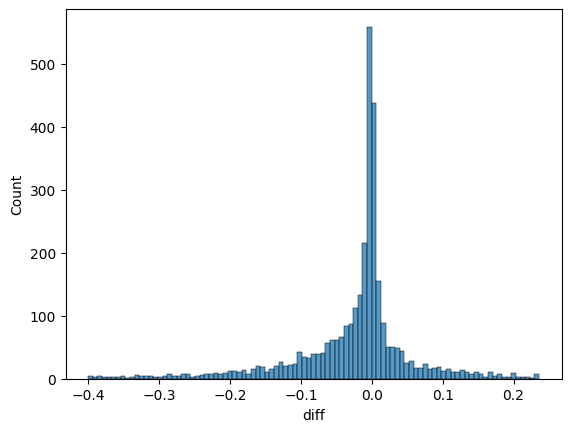

In [439]:
upper, lower = data['diff'].quantile(0.98), data['diff'].quantile(0.02)

sns.histplot(data[data['diff'].between(lower, upper)]['diff'])

In [ ]:
sns.regplot(data = data, x = 'ans_logprob_org_context', y = 'ans_logprob_substitute_context')